# Session 9
Logistic classifier on Loans data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import loans data.
Note that this is the same set we used to pracitce in JMP. For comparison purpose, we keep the same Validation column.

In [2]:
# prompt: import data from here /content/drive/MyDrive/Campus/Master Study/Courses/Fall 2024/DSO-528 Blended Data Business Analytics for Efficient Decisions/In-Class Practice/Session 7/loans_clean.txt, it's a txt file

import pandas as pd

loans = pd.read_csv('/content/drive/MyDrive/Campus/Master Study/Courses/Fall 2024/DSO-528 Blended Data Business Analytics for Efficient Decisions/In-Class Practice/Session 7/loans_clean.txt', sep='\t')


In [3]:
loans.head()

,default,credit.policy,installment,log.annual.inc,fico,inq.last.6mths,revol.bal,Validation
0,0,1,228.22,11.082143,707,0,33623,1
1,0,1,366.86,10.373491,682,1,3511,1
2,0,1,84.12,10.203592,707,1,5630,1
3,0,1,253.58,11.835009,662,2,5122,1
4,0,1,188.02,11.225243,772,1,29797,1


## Set up test and train data.
Test is the set of data with Validation value of 1.

In [4]:
# prompt: in the loans data, set test data as those with Validation value 1, and the rest as train data

train = loans[loans['Validation'] != 1]
test = loans[loans['Validation'] == 1]
train.shape, test.shape

((6705, 8), (2873, 8))

## Build a logistic regression model
To find the statistic report of the model, we may request AI to build the same model using statsmodels library.

In [14]:
# prompt: use sklearn library, for the train data, build a logisitic regression model to predict default (set default = 1 as the target level to predict) using credit.policy and fico, report coefficient and intercept. Build a similar model using sm.logit and report the summary.

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

# Prepare data for sklearn
X_train = train[['credit.policy', 'fico']]
y_train = train['default']

# Build logistic regression model using sklearn
model_sklearn = LogisticRegression()
model_sklearn.fit(X_train, y_train)

print("Sklearn Model Coefficients:")
print("Intercept:", model_sklearn.intercept_[0])
print("Coefficients:", model_sklearn.coef_[0])

# Prepare data for statsmodels
X_train_sm = sm.add_constant(X_train)
model_sm = sm.Logit(y_train, X_train_sm)
result_sm = model_sm.fit()

print("\nStatsmodels Model Summary:")
print(result_sm.summary())


Sklearn Model Coefficients:
Intercept: 5.208001916791115
Coefficients: [-0.67678463 -0.00901225]
Optimization terminated successfully.
         Current function value: 0.421944
         Iterations 6

Statsmodels Model Summary:
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                 6705
Model:                          Logit   Df Residuals:                     6702
Method:                           MLE   Df Model:                            2
Date:                Wed, 25 Sep 2024   Pseudo R-squ.:                 0.04042
Time:                        05:57:15   Log-Likelihood:                -2829.1
converged:                       True   LL-Null:                       -2948.3
Covariance Type:            nonrobust   LLR p-value:                 1.739e-52
                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

In the output above, the first summary is for the logistic model fit using LogisticRegression from sklearn library. The other one is the summary for the model fit using sm.logit from statsmodels. Estimates are similar. Both can be applied to write the regression model. For example, based on the second output, the model is

Log(P1/P0) = 9.3014 - 0.3412*credit.policy - 0.0095*fico + 0.0013*installment - 0.4256*log.annual.inc + 0.0921*inq.last.6mths

Based on the sign of coefficient estimates, the higher the fico scores, the lower likelihood of default probability (P1), holding everything else unchanged. Similarly, loans with credit.policy 1 are less likely to default than the those with 0 credit.policy, holding other conditions unchanged.



## Use the model to predict
Based on the output below, the predicted default probability will increase from 9.7% to 17.6% when credict.policy changes from 1 to 0 (okay to fail), and FICO stays at 750.

In [9]:
# prompt: When credit.policy changes from 0 to 1, and fico score stays at 750, what are the corresponding default probabilities?

import numpy as np

# Extract coefficients from the statsmodels model
intercept = result_sm.params['const']
credit_policy_coef = result_sm.params['credit.policy']
fico_coef = result_sm.params['fico']
installment_coef = result_sm.params['installment']
log_annual_inc_coef = result_sm.params['log.annual.inc']
inq_last_6mths_coef = result_sm.params['inq.last.6mths']

# Define the fico score
fico_score = 750

# Calculate log odds for credit.policy = 0
log_odds_0 = intercept + credit_policy_coef * 0 + fico_coef * fico_score + installment_coef * 0 + log_annual_inc_coef * 0 + inq_last_6mths_coef * 0

# Calculate log odds for credit.policy = 1
log_odds_1 = intercept + credit_policy_coef * 1 + fico_coef * fico_score + installment_coef * 0 + log_annual_inc_coef * 0 + inq_last_6mths_coef * 0

# Calculate probability for credit.policy = 0
prob_0 = np.exp(log_odds_0) / (1 + np.exp(log_odds_0))

# Calculate probability for credit.policy = 1
prob_1 = np.exp(log_odds_1) / (1 + np.exp(log_odds_1))

print("Default probability when credit.policy = 0 and fico = 750:", prob_0)
print("Default probability when credit.policy = 1 and fico = 750:", prob_1)


Default probability when credit.policy = 0 and fico = 750: 0.8100160627445306
Default probability when credit.policy = 1 and fico = 750: 0.7347441534420495


## Show ROC curve for this model

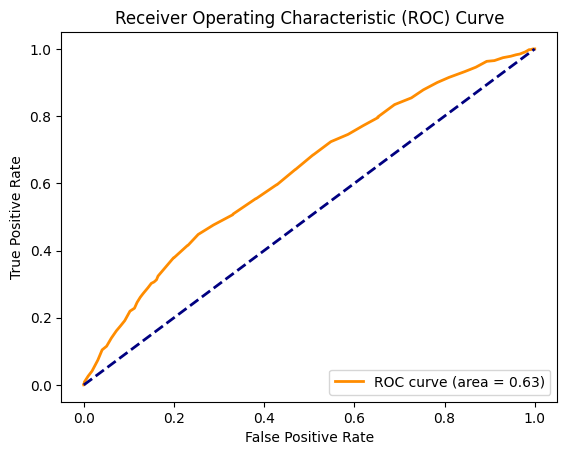

In [15]:
# prompt: construct ROC curve and plot the ROC curve for this model

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the test set
y_pred_prob = model_sklearn.predict_proba(test[['credit.policy', 'fico']])[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(test['default'], y_pred_prob)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Save predicted default probability

In [17]:
# prompt: predict default probability for the test data, add the predicted probability to the test data and save it as a csv file to /content/drive/MyDrive/Colab Notebooks/DSO528/Week5 folder with the name loans528_log

# Predict default probability for the test data
y_pred_prob = model_sklearn.predict_proba(test[['credit.policy', 'fico']])[:, 1]

# Add the predicted probability to the test data
test_with_prob = test.copy()
test_with_prob['predicted_default_prob'] = y_pred_prob

# Save the updated test data as a CSV file
test_with_prob.to_csv('/content/drive/MyDrive/Campus/Master Study/Courses/Fall 2024/DSO-528 Blended Data Business Analytics for Efficient Decisions/In-Class Practice/Session 8/loans528_log_base.csv', index=False)
